In [49]:
# Importing Dependincies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [50]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [51]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, desc

In [52]:
# Creating engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [53]:
# Reflecting an existing database into a new model
Base = automap_base()
# Reflecting the tables
Base.prepare(autoload_with=engine)

In [54]:
# Viewing all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [55]:
# Also view all of the classes using inspector
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [56]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [57]:
# Creating our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [58]:
# Displaying the Measurement row's columns and data in dictionary format
first_row = session.query(Measurement).first()
print(first_row.__dict__)

# Inspecting and displaying the Measurement row's columns type
inspector = inspect(engine)
measurement_columns = inspector.get_columns("Measurement")
for i in measurement_columns:
    print(i["name"], i["type"])

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001E75FE09B50>, 'station': 'USC00519397', 'date': '2010-01-01', 'tobs': 65.0, 'id': 1, 'prcp': 0.08}
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [59]:
# Finding the most recent date in the data set, 2 options shown below

# most_recent_date = session.query(func.max(Measurement.date)).first()
# most_recent_date

most_recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print("Most Recent Measurement Date is: ", most_recent_date)

Most Recent Measurement Date is:  ('2017-08-23',)


In [60]:
# Calculating the date one year from the last date in data set
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Year Ago Date is: ", year_ago)


Year Ago Date is:  2016-08-23


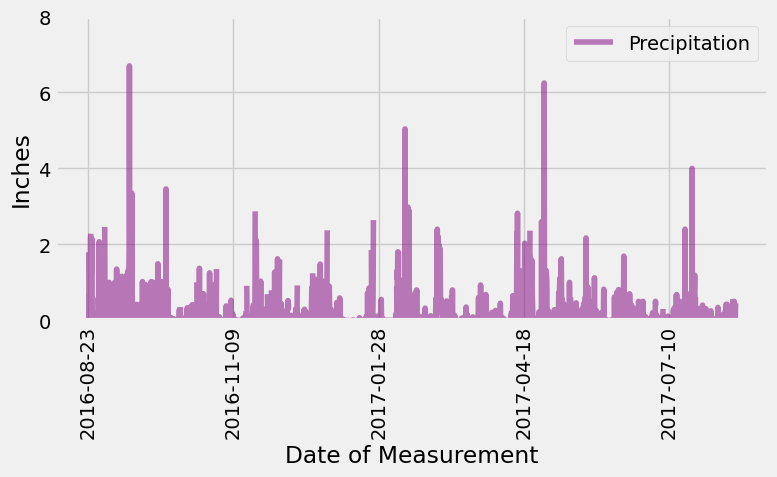

In [61]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results, starting from the most recent data point in the database 

# Saving the query results as a Pandas DataFrame. Explicitly set the column names and sorting by date
one_year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).all()
df = pd.DataFrame(one_year_data, columns=["date", "Precipitation"])
df.set_index("date", inplace=True)
df = df.sort_values("date")

# Using Pandas Plotting with Matplotlib to plot the data
df.plot(color="purple", alpha=0.5, figsize=(8,5))
plt.ylim(0, 8)
plt.xticks(rotation=90)
plt.xlabel("Date of Measurement")
plt.ylabel("Inches")
plt.tight_layout()

#saving to Output folder as jpg
plt.savefig("Output/Precipitation by Date of Measurement.jpg")
plt.show()

# why cant I get more dates data in bar chart??????????????????

In [62]:
# Using Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [63]:
# Displaying the Station row's columns and data in dictionary format
first_row = session.query(Station).first()
print(first_row.__dict__)

# Inspecting and displaying the Station row's columns type
inspector = inspect(engine)
station_columns = inspector.get_columns("Station")
for column in station_columns:
    print(column["name"], column["type"])

# Displaying all stations for a clearer view (descending orderstation id, number and name) 
session.query(Station.id, Station.station, Station.name).order_by(Station.id.desc()).all()

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001E75D796510>, 'id': 1, 'latitude': 21.2716, 'elevation': 3.0, 'name': 'WAIKIKI 717.2, HI US', 'station': 'USC00519397', 'longitude': -157.8168}
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 (4, 'USC00517948', 'PEARL CITY, HI US'),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (1, 'USC00519397', 'WAIKIKI 717.2, HI US')]

In [64]:
# Designing a query to calculate the total number of stations in the dataset, 3 ways can be used

# session.query(Station.station).count()

# session.query(func.count(Station.station)).all()

total_number_of_stations = session.query(func.count(Station.station)).first()
total_number_of_stations

#why .first not .all here above??????????????????????????

(9,)

In [65]:
# Designing a query to find the most active stations, stations which have the most rows
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [66]:
# Using the most active station id from the previous query, calculating the lowest, highest, and average temperature
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

station_USC00519281 = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').first()

station_USC00519281

(54.0, 85.0, 71.66378066378067)

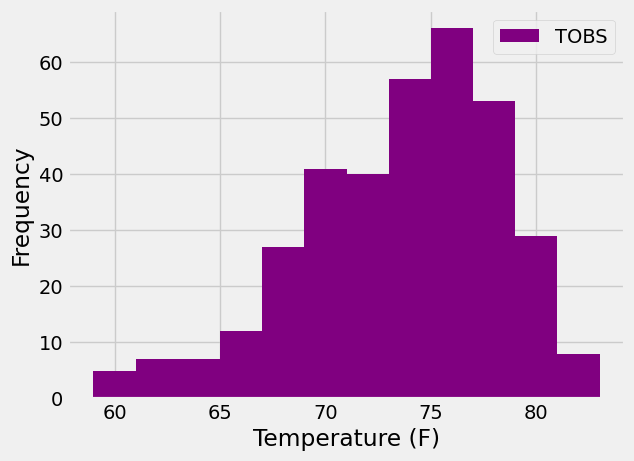

In [67]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Measurement.tobs).\
        filter(Measurement.station == 'USC00519281', Measurement.date >= year_ago).all()

df2 = pd.DataFrame(data, columns=['TOBS'])
df2.plot.hist(bins=12, color = "purple")
plt.xlabel('Temperature (F)')

plt.savefig("Output/Station USC00519281 Temperature Observation.jpg")
plt.show()

# Close Session

In [68]:
# Close Session
session.close()